In [6]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import time
# from google.colab import drive
import os
from sklearn.metrics.pairwise import polynomial_kernel as polykernel

import gc
# def mount():
#   drive.mount('/content/drive')
#   os.chdir("/content/drive/My Drive/SLAss2")
# mount()

In [56]:
K(xone[1], xone[0], 2)

20746.02447524881

In [55]:
polykernel(xone, xone, degree = 2, gamma = 1, coef0 = 0)

array([[40822.7909909 , 20746.02447525,  9031.71850991, ...,
         4139.62195993, 13295.91756781,  5925.01607346],
       [20746.02447525, 44379.28550446, 17829.28267264, ...,
         3649.2412401 , 15336.61309557, 10702.33223561],
       [ 9031.71850991, 17829.28267264, 53826.54646212, ...,
        11772.30468406,  8143.57831612, 34677.14799323],
       ...,
       [ 4139.62195993,  3649.2412401 , 11772.30468406, ...,
        42905.88590777,  2779.70218094, 10221.50824718],
       [13295.91756781, 15336.61309557,  8143.57831612, ...,
         2779.70218094, 42941.53087641,  6843.94812607],
       [ 5925.01607346, 10702.33223561, 34677.14799323, ...,
        10221.50824718,  6843.94812607, 52664.1142667 ]])

In [58]:
import numpy as np
import time
import pandas as pd
from sklearn.metrics.pairwise import polynomial_kernel as polykernel
from scipy.spatial.distance import cdist, pdist, squareform
test = pd.read_csv("data/dtest123.dat", delimiter = "  ", header = None, engine = "python")
train = pd.read_csv("data/zipcombo.dat", delimiter = " ", header = None, engine = "python")
train.shape
minitrain = pd.read_csv("data/dtrain123.dat", delimiter = "  ", header = None, engine = "python")
train = np.array(train)
xtrain = train[:,1:257]
ytrain = train[:,0]
one = np.array(minitrain)
xone = one[:, 1:257]
yone = one[:,0]
test = np.array(test)
xtest = test[:, 1:]
ytest = test[:,0]
class kernel_perceptron:
    def __init__(self, N):
        self.N = N
        self.alpha = np.zeros((self.N, 1))
        self.accs = []
        self.w = np.zeros((N, 1))
    def train(self, K, y, d = 2, epochs = 1, alt = True):
        if len(self.alpha) != len(K):
            self.N = len(K)
            self.alpha = np.zeros((len(K), 1))
        for epoch in range(epochs):
            js = np.arange(self.N)
            np.random.shuffle(js)
            for i in js:
                yhat = np.sign(np.sign((K[:,i].dot(self.alpha))))
                if yhat != y[i]:
                    self.alpha[i] += y[i]

    def predict(self, Ktest):
        return Ktest.T.dot(self.alpha).flatten()

class onevsall:
    def __init__(self, xtrain, ytrain, kernel = "poly", karg = "Default"):
        self.N = len(xtrain)
        self.models = []
        self.x = xtrain
        if kernel == "poly":
            degree = karg if karg != "Default" else 2
            self.K = polykernel(xtrain, xtrain, degree = degree, gamma = 1, coef0 = 0)
            self.K /= self.K.max()
        elif kernel == "rbf":
            c = karg if karg != "Default" else 1
            edist = squareform(pdist(xtrain, metric = "euclidean"))**2
            self.K = np.exp(-c * edist/edist.max())
        else:
            raise ValueError("Invalid Kernel Specified. Must be poly or rbf")



        self.y = ytrain
    
    def train(self):
        self.vals = range(int(max(self.y)+1))
        if len(self.models) == 0:
            self.ytemps = []
            for val in self.vals:
                ytemp = self.y.copy()
                ytemp[ytemp != val] = -1
                ytemp[ytemp == val] = 1
                self.add_model(ytemp)
                self.ytemps.append(ytemp.copy())
        for val in self.vals:
            self.models[val].train(self.K, self.ytemps[val], epochs = 1)

    def add_model(self, ytrain):
        model = kernel_perceptron(self.N)
        self.models.append(model)
    
    def predict(self, x, full = False, test = True):
        ktest = polykernel(self.x, x, degree = 2)
        preds = np.zeros((len(x), len(self.models)))
        for i, model in enumerate(self.models):
            preds[:,i] = model.predict(ktest)
        if full == True:
            return preds
        return preds.argmax(axis = 1)


class onevsone:
    
    def __init__(self, xtrain, ytrain, kernel = "poly", d = 2, ks = None):
        self.N = len(xtrain)
            
    
    def train(self, print_accs = True, alt = False):
        self.vals = range(int(max(self.y)+1))
        self.m = int(max(self.y)+1)
        m = self.m
        if len(self.models) == 0:
            self.Ks = [int(max(self.y+1))*[None] for i in range(int(max(self.y+1)))]
            self.ijs = [int(max(self.y+1))*[None] for i in range(int(max(self.y+1)))]
            self.ys = [int(max(self.y+1))*[None] for i in range(int(max(self.y+1)))]
            self.models = [int(max(self.y+1))*[None] for i in range(int(max(self.y+1)))]
            for i in range(0, m):
                for j in range(1+i, m):
                    ij = np.where((self.y==i)|(self.y==j))[0]
                    self.models[i][j] = kernel_perceptron(len(ij))
                    ij = np.where((self.y==i)|(self.y==j))[0]
                    ktemp = self.K[ij, :]
                    ktemp = ktemp[:,ij]
                    ktemp = ktemp.squeeze()
                    ytemp = self.y[ij]
                    ytemp[ytemp == i] = 1
                    ytemp[ytemp == j] = -1
                    self.Ks[i][j] = ktemp.copy()
                    self.ys[i][j] = ytemp.copy()
                    self.ijs[i][j] = ij
        for i in range(0, m):
            for j in range(1+i, m):
                self.models[i][j].train(self.Ks[i][j], self.ys[i][j])

    
    def predict(self, K):
        n = K.shape[1]
        preds = np.zeros((n, self.m, self.m)) 
        for i in range(0, self.m):
            for j in range(i+1, self.m):
                preds[:,i,j] = model.models[i][j].predict(K[self.ijs[i][j],:])
        scores = np.zeros((n, 10))
        for n, pred in enumerate(preds):
            for i in range(10):
                scores[n,i] += -np.sum(pred[:i, i]) + np.sum(pred[i,i:])
        return np.argmax(scores, axis = 1).flatten()


# model = onevsall(xtrain, ytrain, "poly", 4)
# for i in range(10):
#     model.train()
#     print(np.mean(model.predict(xtrain) == ytrain.flatten()))

In [60]:
yone[yone==3] = 0
model = onevsall(xone, yone, "poly", 2)
for i in range(10):
    model.train()
    print(np.mean(model.predict(xone) == yone.flatten()))

0.5501519756838906
0.5775075987841946
0.47112462006079026
0.47112462006079026
0.47112462006079026
0.47112462006079026
0.47112462006079026
0.47112462006079026
0.47112462006079026
0.47112462006079026


In [44]:
model.K

array([[0.47295916, 0.12312053, 0.02366825, ..., 0.00507172, 0.05091887,
        0.01028593],
       [0.12312053, 0.5585073 , 0.09113198, ..., 0.00395702, 0.06758831,
        0.03312149],
       [0.02366825, 0.09113198, 0.82017428, ..., 0.04000387, 0.01928486,
        0.34184723],
       ...,
       [0.00507172, 0.00395702, 0.04000387, ..., 0.52220583, 0.00231781,
        0.03023915],
       [0.05091887, 0.06758831, 0.01928486, ..., 0.00231781, 0.52306968,
        0.01367501],
       [0.01028593, 0.03312149, 0.34184723, ..., 0.03023915, 0.01367501,
        0.78527996]])

# Import Data

In [3]:
# train = pd.read_csv("dtrain123.dat", delimiter = "  ", header = None)
test = pd.read_csv("data/dtest123.dat", delimiter = "  ", header = None)
train = pd.read_csv("data/zipcombo.dat", delimiter = " ", header = None)
train.shape
minitrain = pd.read_csv("data/dtrain123.dat", delimiter = "  ", header = None)
train = np.array(train)
xtrain = train[:,1:257]
ytrain = train[:,0]
one = np.array(minitrain)
xone = one[:, 1:257]
yone = one[:,0]
test = np.array(test)
xtest = test[:, 1:]
ytest = test[:,0]
def split_data(fullK, jtrain, jtest, y):
    Ktrain = fullK[jtrain][:,jtrain].copy()
    Ktest =  fullK[jtrain][:,jtest].copy()
    ytrain = y[jtrain]
    ytest = y[jtest]
    return Ktrain, ytrain, Ktest, ytest


<ipython-input-3-92240ef60454>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test = pd.read_csv("data/dtest123.dat", delimiter = "  ", header = None)
<ipython-input-3-92240ef60454>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  minitrain = pd.read_csv("data/dtrain123.dat", delimiter = "  ", header = None)


In [ ]:
import sklearn
sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)

In [49]:
class kernel_perceptron:
    def __init__(self, N):
        self.N = N
        self.alpha = np.zeros((self.N, 1))
        self.accs = []
        self.w = np.zeros((N, 1))
    def train(self, K, y, d = 2, epochs = 1, alt = True):
        if len(self.alpha) != len(K):
            self.N = len(K)
            self.alpha = np.zeros((len(K), 1))
        for epoch in range(epochs):
            mistakes = 0
            yhats = np.zeros(self.N)
            js = np.arange(self.N)
            np.random.shuffle(js)
            for i in js:
                yhat = np.sign(np.sign((K[:,i].dot(self.alpha))))
                if yhat != y[i]:
                    self.alpha[i] += y[i]
                    mistakes += 1
                # else:
                #     self.alpha[js[i]] = 0
                yhats[i] = yhat
            self.accs.append(1 - mistakes/self.N)
        return yhats

    
    def predict(self, Ktest):
        return Ktest.T.dot(self.alpha).flatten()
                
def K(p, q, d = 2):
    return (p.T.dot(q))**d

def GaussK(p, q, c):
    print(np.sum((p-q)**2))
    return np.exp(-c * np.sum((p-q)**2))

class onevsall:
    def __init__(self, xtrain, ytrain, xtest = None, ytest = None, kernel = K, d = 2, ks = None):
        self.N = len(xtrain)

        self.models = []
        self.accs = []
        self.testaccs = []
        self.d = d
        self.x, self.xtest = xtrain, xtest
        self.y, self.ytest = ytrain, ytest
        if ks == None:
            self.K = np.zeros((self.N, self.N))
            for i in range(self.N):
                for j in range(i, self.N):
                    # print(self.x[i], self.x[j], d)
                    self.K[i,j] = K(self.x[i], self.x[j], d)
            self.K = self.K + self.K.T - np.diag(self.K.diagonal())
            self.Ktest = np.zeros((self.N, len(self.xtest)))
            for i in range(self.N):
                for j in range(len(self.xtest)):
                    self.Ktest[i,j] = K(self.x[i], self.xtest[j], d)
        else:
            self.N = len(ks[0])
            self.K, self.Ktest = ks
    
    def train(self, print_accs = True, alt = False):
        self.vals = range(int(max(self.y)+1)) # final yval doesn't need model
        if len(self.models) == 0:
            self.ytemps = []
            for val in self.vals:
                ytemp = self.y.copy()
                ytemp[ytemp != val] = -1
                ytemp[ytemp == val] = 1
                self.add_model(ytemp)
                self.ytemps.append(ytemp.copy())
        for val in self.vals:
            self.models[val].train(self.K, self.ytemps[val], epochs = 1, alt = alt)

        if print_accs:
            yhat = self.predict(self.K, self.y)
            acc = np.mean(yhat.reshape(len(yhat), 1) == self.y.reshape(len(yhat), 1))
            self.accs.append(acc)            
            yhattest = self.predict(self.Ktest, self.ytest)
            testacc = np.mean(yhattest.reshape(len(yhattest), 1) == self.ytest.reshape(len(yhattest), 1))
            self.testaccs.append(testacc)
            print(f"Training Accuracy: {acc}. Testing Accuracy: {testacc}")

    def add_model(self, ytrain):
        model = kernel_perceptron(self.N)
        # model.train(self.K, ytrain, epochs = epochs, d = self.d)
        self.models.append(model)
    
    def predict(self, k, full = False, test = True):
        preds = np.zeros((k.shape[1], len(self.models)))
        yhat = np.zeros(k.shape[1])
        for i, model in enumerate(self.models):
            preds[:,i] = model.predict(k)
        if full == True:
            return preds
        return preds.argmax(axis = 1)




## Testing OVO Approach

In [5]:
Kfull = np.load("Gram Matrices/K2")

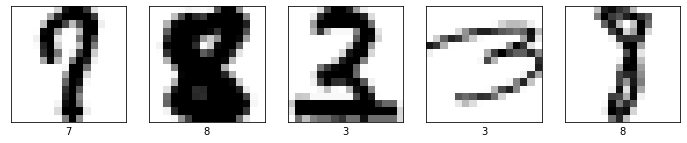

In [105]:
n = len(hardys)
fig, ax = plt.subplots(1, 5, figsize = (12, 12))
for i in range(n):
    ax[i].imshow(xtrain[hardys[i]].reshape(16, 16), cmap = "binary")
    ax[i].set(xticks = [], yticks = [], xlabel = int(ytrain[hardys[i]]))
    

## 1.1
Average of 20 runs w/ 80/20 split for train and test error

In [12]:
ntrain = int(0.2*len(xtrain))
metrics = np.zeros((7, 20, 2))
start = time.time()
for d in range(4, 0, -1):
    print(f"DDDDDD: {d}")
    fullKd = np.load(f"Gram Matrices/K{d}")    
    for i in range(1):
        js = np.arange(len(xtrain))
        np.random.shuffle(js)
        jtrain = js[:ntrain]
        jtest = js[ntrain:ntrain + 500]
        # jtrain = np.arange(0, 5000)
        # rng = np.random.default_rng()
        Ktrain, ytraini, Ktest, ytesti = split_data(fullKd, jtrain, jtest, ytrain)
        model = onevsall(ytraini, ytraini, None, ytesti, d = d, ks = (Ktrain, Ktest))
        for epoch in range(10):
            model.train(False)
        yhat = model.predict(Ktest)
        metrics[d-1,i] = [np.mean(ytraini.reshape(len(ytraini), 1) == model.predict(Ktrain).reshape(len(ytraini), 1))
                          , np.mean(ytesti.reshape(len(ytesti), 1) == yhat.reshape(len(ytesti), 1))]
        print(metrics[d-1, i])
        np.save(open("metrics", "wb"), metrics)
        if i==0:
            print(f"Time Taken: {time.time() - start}")

DDDDDD: 4
[1.    0.934]
Time Taken: 4.534708499908447
[0.99946208 0.952     ]
[1.   0.95]
[0.99946208 0.954     ]
[1.    0.962]
[0.99946208 0.954     ]
[1.    0.966]
[1.   0.95]


KeyboardInterrupt: 

In [16]:
np.save(open("11", "wb"), np.hstack((means, stds)))

# 1.2

In [37]:
ntrain = int(0.8*len(xtrain))
metrics = np.zeros((7, 20, 2))
nfold = int(0.8 * ntrain)
nfoldtest = int(ntrain - nfold)
dstars = np.zeros(20)
testerr = np.zeros(20)
confusion_matrix = np.zeros((10, 10))
cvfullnew = np.zeros((7, 20, 5, 2))
print("Start")
start = time.time()
for i in range(20):
    np.random.seed(i)
    js = np.arange(len(xtrain))
    np.random.shuffle(js)
    jtrain = js[:ntrain]
    jtest = js[ntrain:]
    bestacc = 0
    dstar = 7
    for d in range(1, 2):
        # split into 80/20
        fullKd = np.load(f"K{d}")
        Ktrain, ytraini, Ktest, ytesti = split2(fullKd, jtrain, jtest, ytrain, ntrain)
        # five-fold cross validation
        testacc = 0
        for k in range(5):
            nsplit = int(nfold * k/5)
            ktrain1 = np.arange(0, nsplit+1)
            ktest = np.arange(nsplit+1, nsplit + nfoldtest-1)
            ktrain2 = np.arange(nsplit + nfoldtest-1, nfold)
            ktrain = np.hstack([ktrain1, ktrain2]).flatten()
            Kfoldtrain, yfoldtraini, Kfoldtest, yfoldtesti = split_data(Ktrain, ktrain, ktest, ytraini, nfold)
            model = onevsall(yfoldtraini, yfoldtraini, None, yfoldtesti, d = d, ks = (Kfoldtrain, Kfoldtest))
            for epoch in range(10):
                model.train(False, False)    
            yhat = model.predict(Kfoldtest, yfoldtesti)
            testacc += 0.2 * np.mean(yhat.flatten() == yfoldtesti.flatten())
            cvfullnew[d-1, i, k] = [np.mean(model.predict(Kfoldtrain, yfoldtraini).flatten() == yfoldtraini.flatten()),
                                    np.mean(yhat.flatten() == yfoldtesti.flatten())]
        print(f"{i} run : {d}: {testacc}, {bestacc}, {dstar}")
        np.save(open("fullonevsoneCVFINAL", "wb"), cvfullnew)        
        if testacc > bestacc:
            bestacc = testacc
            dstar = d
    fullKd = np.load(f"K{dstar}")
    Ktrainfinal, ytraini, Ktestfinal, ytesti = split2(fullKd, jtrain, jtest, ytrain, ntrain)
    finalmodel = onevsall(ytrain, ytraini, None, ytesti, ks = (Ktrainfinal, Ktestfinal))
    for epoch in range(10):
        finalmodel.train(False, False)
    finalyhat = finalmodel.predict(Ktestfinal, ytesti)
    dstars[i] = dstar
    testerr[i] = 1 - (finalmodel.predict(finalmodel.Ktest, finalmodel.ytest).flatten() == finalmodel.ytest.flatten()).mean()
    print(f"{i} runs finished. Dstar: {dstar}, Testerr: {testerr[i]}, Time: {time.time() -start}")
    np.save(open("1v1testerrFINAL", "wb"), testerr)
    np.save(open("1v1dstarsFINAL", "wb"), dstars)
    

Start
0 run : 1: 0.9069986541049798, 0, 7


KeyboardInterrupt: 